# Acquiring Data From BigQuery #

In [1]:
from google.cloud import bigquery
client = bigquery.Client()

QUERY = """
        SELECT repo_name, language
        FROM `bigquery-public-data.github_repos.languages`
        LIMIT 10000
        """

query_job = client.query(QUERY)

iterator = query_job.result(timeout=30)
rows = list(iterator)

for i in range(10):
    for j in rows[i].language:
        print j[u'name']
    print 

C
D
Java
JavaScript
OCaml
PHP
Perl
Python
Shell

C
D
Shell

C
R

C
R

C
R

C
C#

C
C#
C++

C
C#
C++

C
C#
C++

C
C#
C++



# List of Languages #

In [2]:
#sourced from githut 
import pandas

df = pandas.read_csv('data/language_names.csv')
names = df['language_name'].tolist()

name_to_index = {}
for j,i in enumerate(names):
    name_to_index[i] = j

# Repository-Language Matrix #

In [3]:
import numpy as np

mat = np.zeros((len(rows),len(names)))
for i,row in enumerate(rows):
    
    for lang in rows[i].language:
        mat[i][name_to_index[lang[u'name']]] = 1

# K-Means #

In [31]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=10)
km.fit(mat)
print np.shape(mat)
print km.labels_
print km.cluster_centers_

(10000, 345)
[2 6 8 ..., 1 6 1]
[[ 0.11967213  0.04262295  0.17213115 ...,  0.          0.          0.        ]
 [ 0.11923276  0.06168999  0.03836185 ...,  0.          0.          0.        ]
 [ 0.32118056  0.26909722  0.28472222 ...,  0.          0.          0.        ]
 ..., 
 [ 0.94922195  0.88943489  0.85257985 ...,  0.          0.          0.        ]
 [ 0.02270742  0.01834061  0.04803493 ...,  0.          0.          0.        ]
 [ 0.38198758  0.44099379  0.38664596 ...,  0.          0.          0.        ]]


# PCA #

In [61]:
from sklearn.decomposition import PCA

#not good enough for visualization
pca = PCA(n_components=2)
transformed = pca.fit_transform(mat[:,:7]) 
print sum(pca.explained_variance_ratio_)
print pca.singular_values_

0.531760029121
[ 66.3974066   49.78771697]


# Visualization #

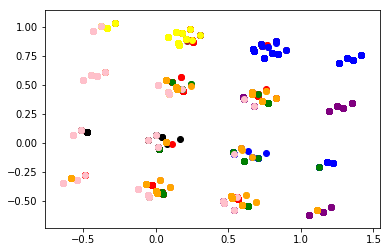

In [63]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = ['black','gray','brown','red','blue','green','yellow','purple','pink','orange']
transformed = np.concatenate((transformed,np.reshape(np.array(km.labels_),(-1,1))),1)
for i in range(10):
    cluster = transformed[transformed[:,2]==i]
    plt.scatter(cluster[:,0],cluster[:,1],color=colors[i])